In [1]:
import rebound
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [40]:
# Binary parameters (Zuniga-Fernandez et al. 2021)
t_ref = 2023     # t_ref = T0_AB

e_B = 0.805
i_B = np.radians(66.3)
a_B = 1.01
m_Ba = 0.77
m_Bb = 0.62
omega_Ba = np.radians(104.5)
omega_Bb = omega_Ba - np.pi
Omega_B = np.radians(342.7)
T0_B = 48707.5
P_B = 314.86
mean_B = np.radians(360*(t_ref - T0_B)/P_B)

e_A = 0.4808
i_A = np.radians(135.6)
a_A = 0.86
m_Aa = 0.93
m_Ab = 0.29
omega_Aa = np.radians(68.7)
omega_Ab = omega_Aa - np.pi
Omega_A = np.radians(170.2)
T0_A = 48742.5
P_A = 264.51
mean_A = np.radians(360*(t_ref - T0_A)/P_A)

e_AB = 0.46
i_AB = np.radians(88.1)
a_AB = 51
m_A = 1.1
m_B = 1.4
omega_A = np.radians(65)
omega_B = omega_A - np.pi
Omega_AB = np.radians(184.5)
T0_AB = 2023
P_AB = 230
mean_AB = np.radians(360*(t_ref - T0_AB)/P_AB)


# Disk parameters (Kennedy et al. 2019)
a_inner = 2.5
a_outer = 4.6
e_disk = 0.03
pos_disk = np.radians(15.6)
inc_disk = np.radians(26)
omega_disk = np.radians(-73)
b_inner = a_inner*np.cos(inc_disk)*(1-e_disk**2)**0.5
b_outer = a_outer*np.cos(inc_disk)*(1-e_disk**2)**0.5


In [41]:
# Build disk

angles = np.linspace(0, 2*np.pi, 100)

x_outer = a_outer*np.cos(angles)
y_outer = b_outer*np.sin(angles)
z_outer = x_outer*np.tan(inc_disk)

x_inner = a_inner*np.cos(angles)
y_inner = b_inner*np.sin(angles)
z_inner = x_inner*np.tan(inc_disk)

# Rotate disk
x_o = x_outer*np.cos(pos_disk) - y_outer*np.sin(pos_disk)
y_o = x_outer*np.sin(pos_disk) + y_outer*np.cos(pos_disk)
x_i = x_inner*np.cos(pos_disk) - y_inner*np.sin(pos_disk)
y_i = x_inner*np.sin(pos_disk) + y_inner*np.cos(pos_disk)

x_inner = x_i
y_inner = y_i
x_outer = x_o
y_outer = y_o

In [4]:
# Create 3 star system - Ba + Bb + A

# Create system B (Ba + Bb)

sim1 = rebound.Simulation()
sim1.units = ('days', 'AU', 'Msun')
sim1.move_to_hel()

Ba = rebound.Particle(simulation=sim1,
                      m=m_Ba,
                     )


Bb = rebound.Particle(simulation=sim1,
                      primary=Ba,
                      m=m_Bb,
                      a=a_B,
                      e=e_B,
                      omega=omega_Bb,
                      inc=i_B,
                      Omega=Omega_B
                     )



sim1.add(Ba)
sim1.add(Bb)
sim1.move_to_com()
Ba, Bb = sim1.particles


# Create AaAb as a single object representing the CoM of AaAb relative to the CoM of BaBb

A = rebound.Particle(simulation=sim1,
                     m=m_A,
                     a=a_AB,
                     e=e_AB,
                     omega=omega_A,
                     inc=i_AB,
                     Omega=Omega_AB
                    )


sim1.add(A)



In [42]:
# Plot orbits

start_time = 0
t_max = 18*365.25 + start_time   # integrate over 18 years
n_steps = int(1e4)
times = np.linspace(start_time, t_max, n_steps)

# Initialise arrays for the orbital parameters of the four stars

x_A, y_A, z_A = np.zeros(n_steps), np.zeros(n_steps), np.zeros(n_steps)  
x_Ba, y_Ba, z_Ba = np.zeros(n_steps), np.zeros(n_steps), np.zeros(n_steps)
x_Bb, y_Bb, z_Bb = np.zeros(n_steps), np.zeros(n_steps), np.zeros(n_steps)


vx_A, vy_A, vz_A = np.zeros(n_steps), np.zeros(n_steps), np.zeros(n_steps)
vx_Ba, vy_Ba, vz_Ba = np.zeros(n_steps), np.zeros(n_steps), np.zeros(n_steps)
vx_Bb, vy_Bb, vz_Bb = np.zeros(n_steps), np.zeros(n_steps), np.zeros(n_steps)

x_transits = []
y_transits = []


Ba, Bb, A = sim1.particles

for i, t in enumerate(times):
    sim1.integrate(t)

    # Calculate the CoM of Ba and Bb
    comB = sim1.calculate_com(first=0, last=2)     
    pos_comB = np.array([comB.x, comB.y, comB.z])
    v_comB = np.array([comB.vx, comB.vy, comB.vz])
    
    # Recenter all components so the CoM of BaBb is at the origin
    x_Ba[i], y_Ba[i], z_Ba[i] = np.array([Ba.x, Ba.y, Ba.z]) - pos_comB
    x_Bb[i], y_Bb[i], z_Bb[i] = np.array([Bb.x, Bb.y, Bb.z]) - pos_comB
    vx_Ba[i], vy_Ba[i], vz_Ba[i] = np.array([Ba.vx, Ba.vy, Ba.vz]) - v_comB
    vx_Bb[i], vy_Bb[i], vz_Bb[i] = np.array([Bb.vx, Bb.vy, Bb.vz]) - v_comB
    
    x_A[i], y_A[i], z_A[i] = np.array([A.x, A.y, A.z]) - pos_comB
    vx_A[i], vy_A[i], vz_A[i] = np.array([A.vx, A.vy, A.vz]) - v_comB
    
    # Rotate disk and A to y=0 to determine when transit is happening     
    x, y = x_A[i], y_A[i]
    r = (x**2 + y**2)**0.5      # x=r, y=0 after rotation
    theta = np.arctan2(y,x)
        
    phi = pos_disk - theta    # effective arg of periapsis of disk (in relation to A)
    
    F_inner = (a_inner**2)*(b_inner**2)
    F_outer = (a_outer**2)*(b_outer**2)
    A_inner =  (a_inner**2)*(np.sin(phi)**2) + (b_inner**2)*(np.cos(phi)**2)
    A_outer =  (a_outer**2)*(np.sin(phi)**2) + (b_outer**2)*(np.cos(phi)**2)
    
    
    x_inner2 =  (F_inner/A_inner)**0.5
    x_outer2 = (F_outer/A_outer)**0.5

    if x_inner2 < r < x_outer2:
        x_transits.append(x_A[i])
        y_transits.append(y_A[i])
        
    

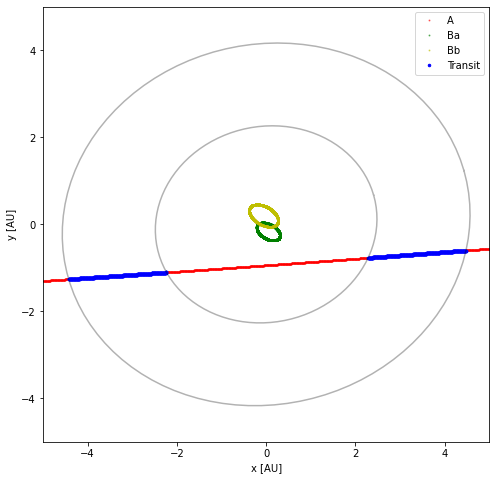

In [43]:
# Make 2D plot
fig1 = plt.figure(1, figsize=(8,8))
from matplotlib import cm
# cm.jet(transit_cmap)

plt.plot(x_A, y_A, 'r.', alpha = 0.5, markersize=2, label='A')
plt.plot(x_Ba, y_Ba, 'g.', alpha = 0.5, markersize=2, label='Ba')
plt.plot(x_Bb, y_Bb, 'y.', alpha = 0.5, markersize=2, label='Bb')
plt.plot(x_transits, y_transits, 'b.', markersize=5, label = 'Transit')

plt.plot(x_inner, y_inner, 'k', alpha=0.3)
plt.plot(x_outer, y_outer, 'k', alpha=0.3)
plt.xlim(-5,5)
plt.ylim(-5,5)
plt.xlabel('x [AU]')
plt.ylabel('y [AU]')
plt.legend()

In [35]:
print(x_transits[-1], y_transits[-1])

4.825132739389075 -0.5738797118492154
